In [1]:
from google.colab import files
uploaded = files.upload()

Saving 中债国债收益率曲线.xls to 中债国债收益率曲线.xls


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import io
from google.colab import files
import random

In [3]:
# 数据预处理：需要建立训练集和测试集。训练集的输入为前n天的利率，输出为第二天的数据；测试集一样
# 首先定义一个类，调用此类可以将数据自动分为训练集和测试集，并分出输入数据与输出数据
class DataProcessing:
    def __init__(self, file, train):
        self.file = file                                # 读取数据
        self.train = train                              # 训练集所占比例     
        self.i = int(self.train * len(self.file))       # 训练集大小（具体数字）
        self.stock_train = self.file[0: self.i]         # 得到训练集
        self.stock_test = self.file[self.i:]            # 得到测试集
        self.input_train = []
        self.output_train = []
        self.input_test = []
        self.output_test = []

    def gen_train(self, seq_len):
        """
        Generates training data
        :param seq_len: length of window
        :return: X_train and Y_train
        """
        for i in range((len(self.stock_train)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_train.iloc[i:i+seq_len], np.float64)
            y = np.array(self.stock_train.iloc[i+seq_len], np.float64)
            self.input_train.append(x)
            self.output_train.append(y)
        self.X_train = np.array(self.input_train)
        self.Y_train = np.array(self.output_train)

    def gen_test(self, seq_len):
        """
        Generates test data
        :param seq_len: Length of window
        :return: X_test and Y_test
        """
        for i in range((len(self.stock_test)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_test.iloc[i:i+seq_len], np.float64)
            y = np.array(self.stock_test.iloc[i+seq_len], np.float64)
            self.input_test.append(x)
            self.output_test.append(y)
        self.X_test = np.array(self.input_test)
        self.Y_test = np.array(self.output_test)

In [4]:
# 读取并处理中债国债收益率曲线数据，由于40及50年期限国债到期收益率从2009年11月30日之前数据缺失，所以分开处理
# 分开后的数据整体完整，去掉NA数据并不影响分析结果
national_debt = pd.read_excel('中债国债收益率曲线.xls', parse_dates=True)
#national_debt = national_debt.iloc[1:(national_debt.shape[0]-2),1:]
national_debt = national_debt.iloc[1:len(national_debt)-2,1:]
national_debt_s = national_debt.iloc[:,:national_debt.shape[1]-2].dropna()
national_debt_l = national_debt.iloc[:,national_debt.shape[1]-2:].dropna()

In [5]:
data = pd.DataFrame(national_debt_s.iloc[:,15])
data.head()

,中债国债到期收益率:10年
1060,2.9291
1069,3
1070,3.048
1071,3.05
1076,3


In [6]:
### standardize the data:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = pd.DataFrame(scaler.fit_transform(data))

In [11]:
p = 0.8
n = 100
e = 100
process_data = DataProcessing(data_scaled, p)
process_data.gen_test(n)
process_data.gen_train(n)
    
# reshape训练集和测试集，用来建立模型ß
r_train = int((len(data)*p//n)*n - n - 1)
r_test = int((len(data)*(1-p)//n)*n - n - 1)
x_train = process_data.X_train.reshape((r_train,n,1))
y_train = process_data.Y_train.reshape((r_train,1,1))
x_test = process_data.X_test.reshape((r_test,n,1))
y_test = process_data.Y_test.reshape((r_test,1,1))

# 将数据转化成可用于 Tensorflow 使用的 float 形式：
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_test = K.cast_to_floatx(x_test)
y_test = K.cast_to_floatx(y_test)

In [12]:
### 建立一个callback的class：
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.01):
      print('\nLoss is low so cancelling training!')
      self.model.stop_training = True
callbacks = myCallback()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [13]:
# 建立 LSTM 模型：
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(100, input_shape=(n, 1), return_sequences=True))
#lstm_model.add(tf.keras.layers.BatchNormalization())
lstm_model.add(tf.keras.layers.Dropout(0.5))
lstm_model.add(tf.keras.layers.LSTM(50))
#lstm_model.add(tf.keras.layers.BatchNormalization())
lstm_model.add(tf.keras.layers.Dropout(0.5))
lstm_model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

In [14]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mean_squared_error")
#lstm_model.fit(x_train, y_train, epochs=e, callbacks=[callbacks])
lstm_model.fit(x_train, y_train, epochs=e, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping_cb])

Epoch 1/100
85/85 [==============================] - 11s 135ms/step - loss: 0.0237 - val_loss: 0.0010
Epoch 2/100
85/85 [==============================] - 11s 132ms/step - loss: 0.0097 - val_loss: 6.9054e-04
Epoch 3/100
85/85 [==============================] - 11s 135ms/step - loss: 0.0077 - val_loss: 6.7965e-04
Epoch 4/100
85/85 [==============================] - 11s 126ms/step - loss: 0.0068 - val_loss: 8.6215e-04
Epoch 5/100
85/85 [==============================] - 11s 125ms/step - loss: 0.0066 - val_loss: 5.9686e-04
Epoch 6/100
85/85 [==============================] - 11s 127ms/step - loss: 0.0063 - val_loss: 0.0010
Epoch 7/100
85/85 [==============================] - 11s 128ms/step - loss: 0.0058 - val_loss: 5.6025e-04
Epoch 8/100
85/85 [==============================] - 11s 128ms/step - loss: 0.0055 - val_loss: 6.4787e-04
Epoch 9/100
85/85 [==============================] - 11s 131ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 10/100
85/85 [==============================] - 11s 

In [15]:
test_predict = pd.DataFrame(lstm_model.predict(x_test))
data_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(test_predict)))

In [16]:
test_y = scaler.inverse_transform(pd.DataFrame(y_test.reshape(r_test,1).tolist()))
test_y = pd.DataFrame(test_y)

In [17]:
from scipy import stats
stats.ttest_ind(data_predict, test_y)

Ttest_indResult(statistic=array([-0.04616821]), pvalue=array([0.96318389]))

No handles with labels found to put in legend.


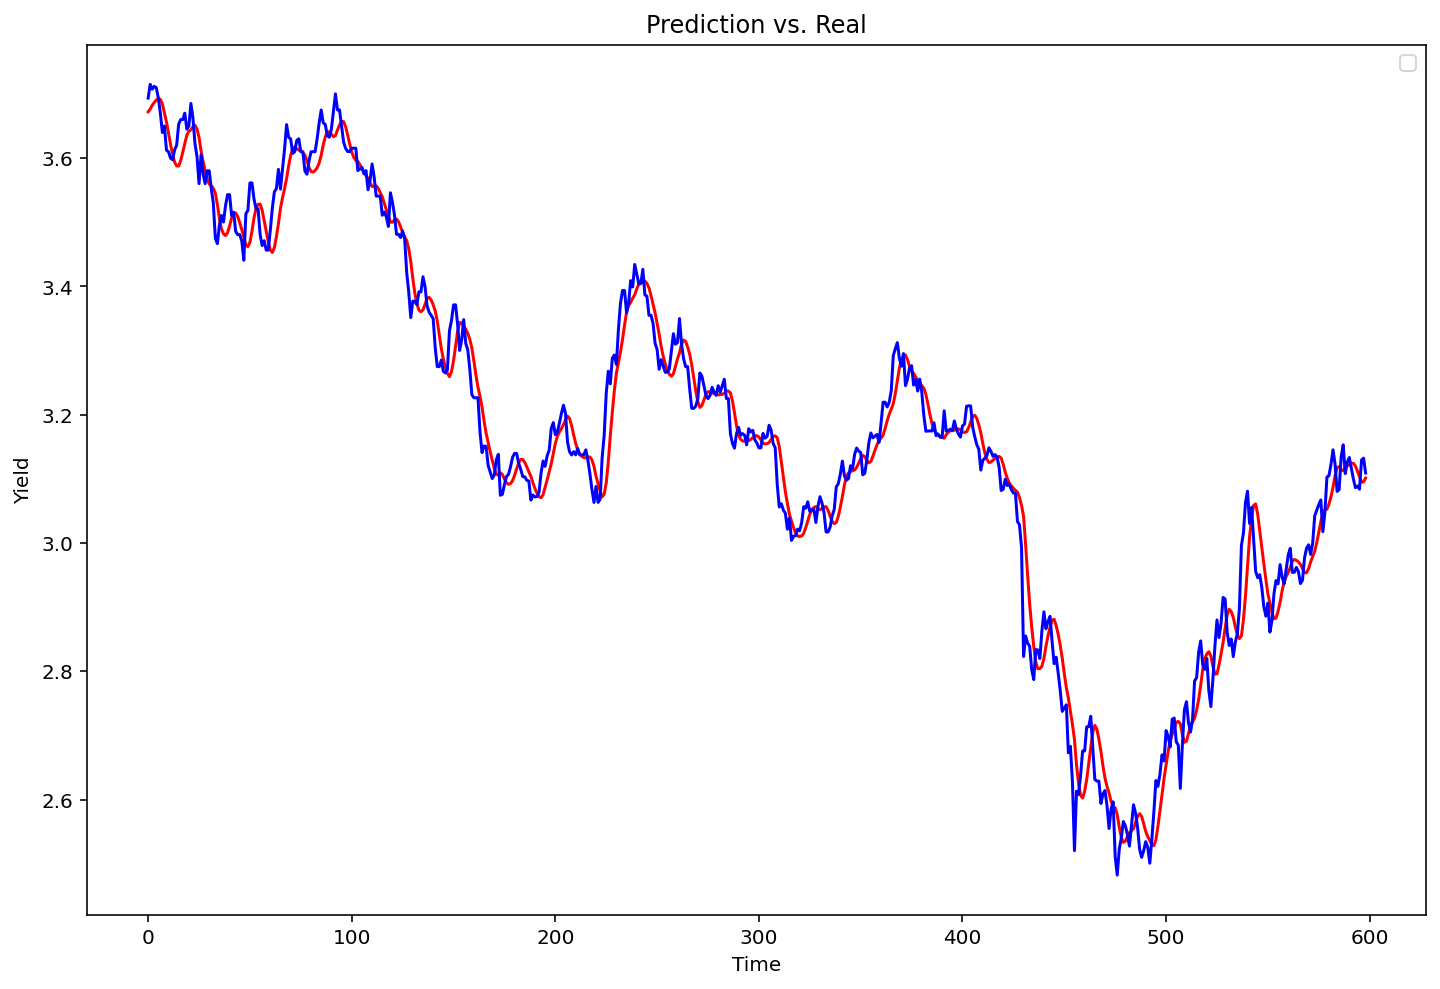

In [18]:
plt.figure(figsize=(12,8))
plt.plot(data_predict, color='red')
plt.plot(test_y, color='blue')
plt.title('Prediction vs. Real')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend();

In [19]:
from itertools import chain
result = []
data_for_predict = data_scaled[-n:].values.tolist()

In [20]:
i = 1
while i <= 30:
  x_predict = np.array(data_for_predict).reshape((1,n,1))
  x_predict = K.cast_to_floatx(x_predict)
  data_predict = lstm_model.predict(x_predict)
  data_predict.tolist()
  data_predict = list(chain(*data_predict))
  data_for_predict.append(data_predict)
  data_for_predict = data_for_predict[-n:]
  #for j in range(len(data_predict)):
  #  data_for_predict.append(data_predict[j])
  #data_for_predict = data_for_predict[-n:]
  result.append(data_predict)
  i += 1
final_result = []
for lst in result:
  final_result.extend(lst)

final_result = scaler.inverse_transform(pd.DataFrame(final_result))
final_result = pd.DataFrame(final_result)[:17]
final_result

,0
0,3.174689
1,3.173904
2,3.173087
3,3.172199
4,3.171241
5,3.170231
6,3.169189
7,3.168129
8,3.167064
9,3.166003
